In [15]:
from PIL import Image, ImageDraw, ImageFont, ImageOps
import string
import random
import cv2
import re
import os
import numpy as np
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont, ImageOps
from scipy import ndimage
import string
from read_classic import metrics
import random
import cv2
import re
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import cm
from generate.characters_generate import generate_characters
from generate.plates_generate import create_plates
from read_classic.train_model_characters import create_and_train_model, convert_to_text
from utils import load_bw_images_dict_from_folder

In [2]:
# NEW
def get_center(rect):
    return rect[0], rect[1]

In [3]:

def split_in_two_lines(rects, deviation):
    for first_line_first_index in range(0, len(rects)):
        for first_line_second_index in range(0, len(rects)):
            if first_line_first_index != first_line_second_index:
                first_line_rect_indices = [first_line_first_index, first_line_second_index]
                line_1_rects = [rects[first_line_rect_indices[0]], rects[first_line_rect_indices[1]]]
                second_line_rect_indices = []
                line_2_rects = []

                point1 = get_center(line_1_rects[0])
                point2 = get_center(line_1_rects[1])
                eps = 10 ^ (-5)

                line_1_m = (point2[1] - point1[1]) / (point2[0] - point1[0] + eps)
                line_1_b = point1[1] - (line_1_m * point1[0])
                line_2_m = 0
                line_2_b = 0

                are_two_parallel_lines = True

                for i in range(0, len(rects)):
                    center = get_center(rects[i])

                    if i in first_line_rect_indices or i in second_line_rect_indices:
                        continue
                    else:
                        line_1_y = line_1_m * center[0] + line_1_b
                        line_2_y = line_2_m * center[0] + line_2_b

                        if abs(center[1] - line_1_y) < deviation:
                            line_1_rects.append(rects[i])
                            first_line_rect_indices.append(i)
                        elif len(line_2_rects) > 1:
                            if abs(center[1] - line_2_y) < deviation:
                                line_2_rects.append(rects[i])
                                second_line_rect_indices.append(i)
                            else:
                                are_two_parallel_lines = False
                                break
                        else:
                            line_2_rects.append(rects[i])
                            second_line_rect_indices.append(i)
                            point = get_center(line_2_rects[0])
                            line_2_m = line_1_m
                            line_2_b = point[1] - (line_2_m * point[0])

                if are_two_parallel_lines:
                    if line_1_b < line_2_b:
                        return line_1_rects, line_2_rects
                    else:
                        return line_2_rects, line_1_rects
                    
    print("Something went wrong, 2liner didnt find correct answer")
    print(rects, deviation)
    return line_1_rects, line_2_rects

In [4]:

def get_box_points(x, y, w, h, alpha):
    return cv2.boxPoints(((x, y), (w, h), alpha))

In [5]:
# Fix the wrong formula (now rects are rotated, so formula for x2, y2 is wrong)
# NEW
def remove_overlapping_bounding_rects(bounding_rects, overlap_percent):
        overlapped_indices = []
        max_idx = len(bounding_rects)
        for chosen_rect_idx in range(0, max_idx):
            x1, y1, w1, h1, alpha1 = bounding_rects[chosen_rect_idx]
            area1 = w1 * h1
            for j in range(chosen_rect_idx, max_idx):
                if chosen_rect_idx != j:
                    x2, y2, w2, h2, alpha2 = bounding_rects[j]
                    x_overlap = max(0, min(x1 + w1/2, x2 + w2/2) - max(x1-w1/2, x2-w2/2))
                    y_overlap = max(0, min(y1 + h1/2, y2 + h2/2) - max(y1-h1/2, y2-h2/2))
                    area_overlap = x_overlap * y_overlap
                    area2 = w2 * h2
                    if area_overlap > overlap_percent * min(area1, area2):
                        if area1 < area2:
                            overlapped_indices.append(chosen_rect_idx)
                        else:
                            overlapped_indices.append(j)
        k = len(bounding_rects)
        overlapped_indices = list(dict.fromkeys(overlapped_indices))
        np_output = np.array(bounding_rects)
        np_output = np.delete(np_output, overlapped_indices, 0)
        return np_output.tolist()

In [6]:

# Get a segment of size (15, 20) - the same size as characters in database
def get_square_segment(x, y, w, h, alpha, size, gray, i):
    box = get_box_points(x, y, w, h, alpha)
    box = np.int0(box)
    # print(box)
    # the order of the box points: first the lowest one, and then clockwise from there.
    # So it can be: bottom left, top left, top right, bottom right
    # Or it can be: bottom right, bottom left, top left, top right
    # Check which case is that now:
    # print(alpha)
    if alpha >= 45:
        last_box_point = box[3].copy()
        box[3] = box[2]
        box[2] = box[1]
        box[1] = box[0]
        box[0] = last_box_point
    src_pts = box.astype("float32")
    # coordinate of the points in box points after the rectangle has been straightened
    dst_pts = np.array([[0, h - 1], [0, 0], [w - 1, 0], [w - 1, h - 1]], dtype="float32")
    # the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    # directly warp the rotated rectangle to get the straightened rectangle
    warped = cv2.warpPerspective(gray, M, (int(w), int(h)))
    warped = Image.fromarray(warped, mode="L")
    # warped = ImageOps.expand(warped, border=5, fill='white')
    if (size != None):
        warped = warped.resize((size - 5, size))
    else:
        warped = warped.resize((int(h), int(w)))
    warped = np.array(warped)
    # if (i!=None):
        # cv2.imshow("warped" + str(i), warped)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

    return warped


In [7]:

# 9000 is empirical value - only 8 sometines doesn't satisfy
def is_segment_dash(img):
    print(ndimage.variance(img))
    return ndimage.variance(img) < 9000


In [8]:
import numpy as np
import math

def transform_rectangle(x, y, w, h, alpha):
    if alpha == 90.0:
        return x, y, h, w, 0.0
    return x, y, w, h, alpha

In [11]:
def detect_lp(gray, text):
   # Try dilation-erosion to make bigger whitespaces between letters - didn't work
   # kernel = np.ones((2, 2), np.uint8)
   # Using cv2.dilate() method
   # gray = cv2.dilate(gray, kernel)

   # Tried dilation+erosion to get rid of white D letter, but not worked since it noises up the plate text too.

   # Apply Canny edge detection
   # gray = cv2.Canny(np.uint8(gray), 50, 150)
   '''Find contours in the image'''
   # cv2.findContours finds arbitrary template in the grayscale image using Generalized Hough Transform
   contours, _ = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
   bounding_rects = []
   
   for cnt in contours:
        # Get rectangle bounding contour
        (x, y), (w, h), alpha = cv2.minAreaRect(cnt)
        x, y, w, h, alpha = transform_rectangle(x, y, w, h, alpha)  # to rotate those with alpha = 90

        # Don't plot small false positives that aren't license plates
        # Height can be really small though (in case of dash)
        if w > 35 or h > 35 or min(w, h) < 4:
            continue
        bounding_rects.append([x, y, w, h, alpha])

    # Removing letter D as the most left rectangle and all the defined rectangles that overlap with it
   most_left_rect = min(bounding_rects, key=lambda t: t[0])
   bounding_rects.remove(most_left_rect)
   chosen_x1, chosen_y1, chosen_h, chosen_w, chosen_alpha = most_left_rect
   # Fix the wrong formula (now rects are rotated, so formula for x2, y2 is wrong)
   chosen_x2, chosen_y2 = chosen_x1 + chosen_w, chosen_y1 + chosen_h
   for rect in bounding_rects:
       x1, y1, w, h, alpha = rect
       x2, y2 = x1 + w, y1 + h
       if (x1 < chosen_x2 and x2 > chosen_x1 and y1 < chosen_y2 and y2 > chosen_y1):
           bounding_rects.remove(rect)
    
    # '''Draw the rectangles around the characters in license plate'''
    # rgb_image = np.repeat(gray[:, :, np.newaxis], 3, axis=2)
    # for [x, y, h, w, alpha] in bounding_rects:
    #     box = get_box_points(x, y, h, w, alpha)
    #     box = np.int0(box)
    #     cv2.drawContours(rgb_image, [box], 0, (0, 0, 255), 1)
    # plt.imshow(rgb_image)
    # plt.show()
    
    # print(len(bounding_rects))
    # Remove overlapping bounding rectangles
   bounding_rects = remove_overlapping_bounding_rects(bounding_rects, 0.5)
    # print("After removing overlapping bounding rectangles: ", bounding_rects)


    # print(len(bounding_rects))

    # '''Draw the rectangles around the characters in license plate'''
    # rgb_image = np.repeat(gray[:, :, np.newaxis], 3, axis=2)
    # for [x, y, h, w, alpha] in bounding_rects:
    #     box = get_box_points(x, y, h, w, alpha)
    #     box = np.int0(box)
    #     cv2.drawContours(rgb_image, [box], 0, (0, 0, 255), 1)
    # plt.imshow(rgb_image)
    # plt.show()
   '''Check if the license plate is 1-liner or 2-liners'''
   is_one_line = True
   bounding_rects_centers = []
   for rect in bounding_rects:
       bounding_rects_centers.append(get_center(rect))
   deviation = 8

   # Fit a line to the points using the numpy polyfit function
   line_coefs = np.polyfit([point[0] for point in bounding_rects_centers],
                            [point[1] for point in bounding_rects_centers], 1)

   # Calculate the y-coordinates for the line at each x-coordinate
   line_y_values = [line_coefs[0] * x + line_coefs[1] for x, _ in bounding_rects_centers]

   # Check the deviation of each point from the line
   for point, line_y in zip(bounding_rects_centers, line_y_values):
       if abs(point[1] - line_y) > deviation:
           is_one_line = False

   # print(is_one_line)
    
   '''Sort the segments in the correct order'''
   if is_one_line:
       bounding_rects.sort(key=lambda r: r[0])
   else:
       first_line, second_line = split_in_two_lines(bounding_rects, deviation)
       first_line.sort(key=lambda r: r[0])
       second_line.sort(key=lambda r: r[0])
       first_line.extend(second_line)
       bounding_rects = first_line
        
   ''' Convert all the segments in the separate images of the correct size (15*20 - same as chars in database)'''
   img_list = [get_square_segment(x, y, w, h, alpha, 20, gray, i) for i, [x, y, w, h, alpha] in
               enumerate(bounding_rects)]
   predicted_text = convert_to_text(img_list)
        
   '''If the bounding rectangle is too wide and short- it is probably a dash'''
   for i, [x, y, w, h, alpha] in enumerate(bounding_rects):
       if ((w > (h * 2) and alpha < 45) or (h > (w * 2) and alpha > 45)) and i != 0 and i != len(bounding_rects) - 1:
           print("adding dash because of dimensions: ", w, h)
           predicted_text[i] = "-"
    
   '''Try check variance of segment to recognize dashes'''
   # for i, img in enumerate(img_list):
   #     if is_segment_dash(img):
   #         predicted_text[i] = "-"

   '''Draw the rectangles around the characters in license plate'''
   rgb_image = np.repeat(gray[:, :, np.newaxis], 3, axis=2)
   for [x, y, w, h, alpha] in bounding_rects:
       box = get_box_points(x, y, w, h, alpha)
       box = np.int0(box)
       cv2.drawContours(rgb_image, [box], 0, (0, 0, 255), 1)

   return rgb_image, "".join(predicted_text)

In [13]:
# Number of plates (right now in 'plates' folder there's 7k images
N = 100
#generate_characters(N)
create_plates(N)  # to generate a folder 'plates' with N images and masks with N images
# model = create_and_train_model()

images_dict = load_bw_images_dict_from_folder("database/plates")
images = list(images_dict.values())
images_platenames = list(images_dict.keys())

In [72]:
generate_characters(N)

In [13]:
# generate_characters(N)
from matplotlib import pyplot as plt

Image number  0
Real text:  A-NW5
Predicted text:  A-NW5


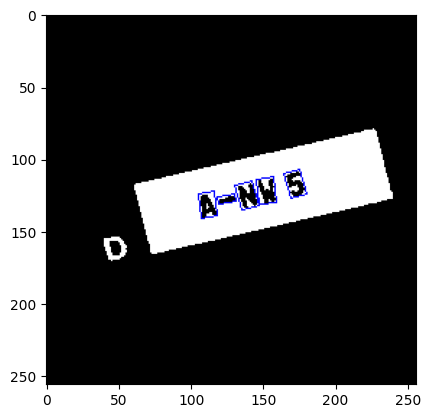

Image number  1
Real text:  A-XL4
Predicted text:  NXL4


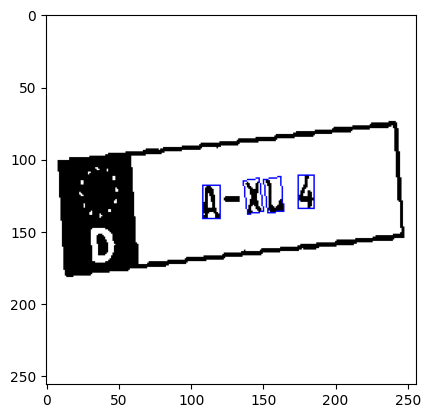

Image number  2
Real text:  ABIW1
Predicted text:  ABDW1


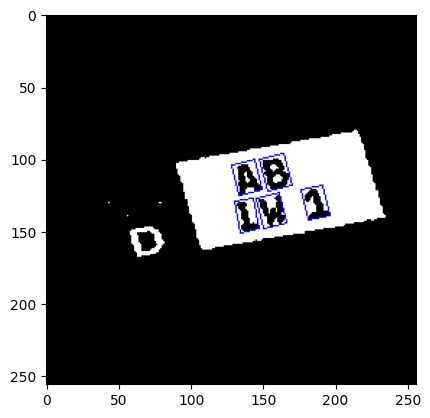

Image number  3
Real text:  ABULV2847
Predicted text:  ABULWZB1


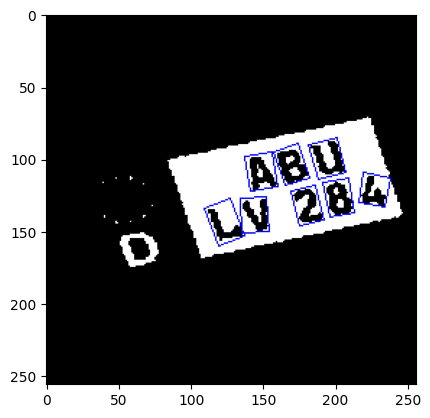

Image number  4
Real text:  ABYJ314
Predicted text:  ABY3310


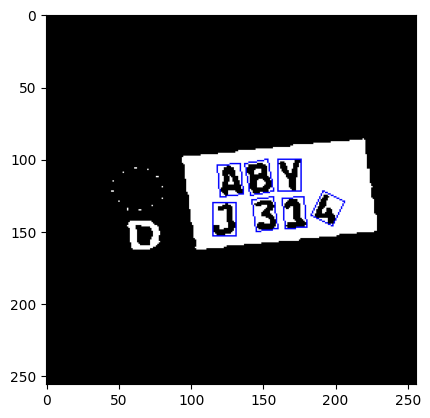

: 

In [23]:
for i in range(0, 5):
    test_idx = i
    img_with_contours, predicted_text = detect_lp(images[test_idx], images_platenames[test_idx])
    print("Image number ", test_idx)
    print("Real text: ", images_platenames[test_idx][0:images_platenames[test_idx].find('.')])
    print("Predicted text: ", predicted_text)
    plt.imshow(img_with_contours)
    plt.show()


Image number  0
Real text:  AEF6801
Predicted text:  NEF6802


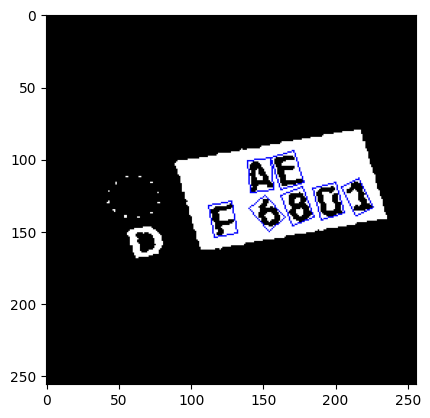

Image number  1
Real text:  AHX5670
Predicted text:  AHX56J0


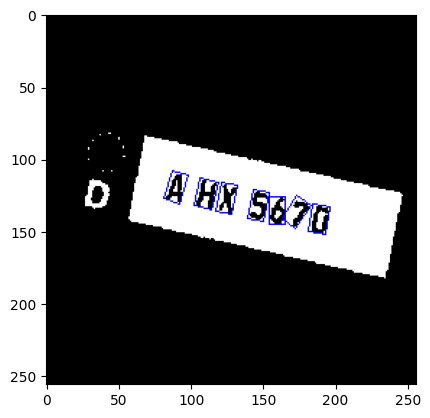

Image number  2
Real text:  AM298
Predicted text:  PMZ98


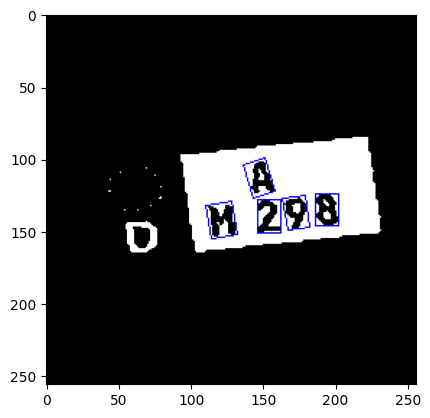

Image number  3
Real text:  APM17
Predicted text:  NPM27


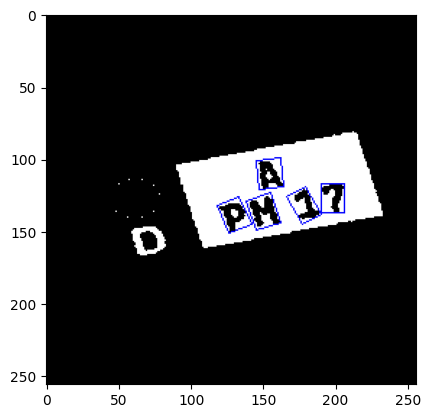

Image number  4
Real text:  ARJ3
Predicted text:  ARW3


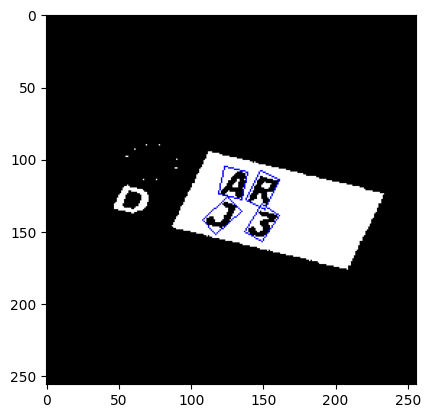

In [73]:
'''Let's try first rotate back the whole image, and then get contours in only non-rotated rectangles form'''
for i in range(0, 5):
    test_idx = i
    img_with_contours, predicted_text = detect_lp(images[test_idx], images_platenames[test_idx])
    print("Image number ", test_idx)
    print("Real text: ", images_platenames[test_idx][0:images_platenames[test_idx].find('.')])
    print("Predicted text: ", predicted_text)
    plt.imshow(img_with_contours)
    plt.show()

Image number  2
Real text:  BCQ2427
Predicted text:  BC02721


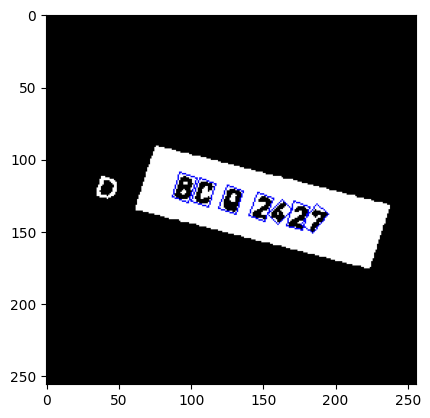

In [16]:
i = 2
image = images[i]
img_with_contours, predicted_text = detect_lp(image, images_platenames[i])
text = images_platenames[i][0:images_platenames[i].find('.')]

print("Image number ", i)
print("Real text: ", text)
print("Predicted text: ", predicted_text)
plt.imshow(img_with_contours)
plt.show()

In [17]:
test_size = 10
misident_dict = {}
avg_percent_of_correct_placed_chars = 0.0
avg_length_identical = 0
avg_text_identical = 0

for i, image in enumerate(images):
        img_with_contours, predicted_text = detect_lp(image, images_platenames[i])
        text = images_platenames[i][0:images_platenames[i].find('.')]
    
        print("Image number ", i)
        print("Real text: ", text)
        print("Predicted text: ", predicted_text)
    
        for c_pos, c in enumerate(text):
            if (len(predicted_text)>c_pos and predicted_text[c_pos]!=c):
                if c not in misident_dict:
                    misident_dict[c] = [predicted_text[c_pos]]
                else:
                    misident_dict[c].append(predicted_text[c_pos])
    
        avg_percent_of_correct_placed_chars += metrics.get_correct_placed_chars_percent(text, predicted_text)
        avg_length_identical += metrics.is_length_same(text, predicted_text)
        avg_text_identical +=  metrics.is_text_same(text, predicted_text)
    
        if (metrics.is_length_same(text, predicted_text) == False):
            print("\n Length is different!")
            plt.imshow(img_with_contours)
            plt.show()
    
        if i >= 9:
            break
    
avg_percent_of_correct_placed_chars /= test_size
avg_length_identical_percent = avg_length_identical / test_size
avg_text_identical_percent = avg_text_identical / test_size
print("avg_percent_of_correct_placed_chars: ", avg_percent_of_correct_placed_chars)
print("avg_length_identical_percent: ", avg_length_identical_percent)
print("avg_text_identical_percent: ", avg_text_identical_percent)

adding dash because of dimensions:  4.808326244354248 12.162237167358398
Image number  0
Real text:  A-LL470
Predicted text:  N-T4470
Image number  1
Real text:  AYYT1
Predicted text:  AMYT1
Image number  2
Real text:  BCQ2427
Predicted text:  BC02721
Image number  3
Real text:  BGBB56
Predicted text:  BG8B51
Image number  4
Real text:  BKJC3
Predicted text:  BKJC3
Image number  5
Real text:  CBB3995
Predicted text:  C8B3D95
Image number  6
Real text:  CGZ1340
Predicted text:  CGZI3D0
Image number  7
Real text:  DKGHG29
Predicted text:  DXGMB24
Image number  8
Real text:  DRYMD0234
Predicted text:  DRIMD0230
adding dash because of dimensions:  12.279438018798828 5.829632759094238
Image number  9
Real text:  E-A12
Predicted text:  E-A22
Image number  10
Real text:  EHYS3
Predicted text:  EHYS3
avg_percent_of_correct_placed_chars:  0.8044444444444444
avg_length_identical_percent:  1.1
avg_text_identical_percent:  0.2


In [19]:
avg_length_identical

11